<a href="https://colab.research.google.com/github/sowmen/Deepfake-Challenge-Kaggle/blob/master/Copy_of_cnn_baseline_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageChops
import gc
import os, sys, time
import math
import random
import cv2
from tqdm import tqdm_notebook as tqdm
%matplotlib inline
pd.set_option('max_colwidth', None)

import warnings
warnings.filterwarnings('ignore')
from random import shuffle

import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard

In [0]:
tensorflow.test.is_gpu_available(
    cuda_only = True,
    min_cuda_compute_capability = None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [0]:
Image_dimension = 200

In [0]:
dataframe = pd.read_csv('/content/drive/My Drive/dataset_0_22.csv')

In [0]:
dataframe.head()

,filename,label,split,original,video_path
0,owxbbpjpch.mp4,1,train,wynotylpnm.mp4,/content/drive/My Drive/Dataset/dfdc_train_part_0/owxbbpjpch.mp4
1,vpmyeepbep.mp4,0,train,NaN,/content/drive/My Drive/Dataset/dfdc_train_part_0/vpmyeepbep.mp4
2,fzvpbrzssi.mp4,0,train,NaN,/content/drive/My Drive/Dataset/dfdc_train_part_0/fzvpbrzssi.mp4
3,htorvhbcae.mp4,1,train,wclvkepakb.mp4,/content/drive/My Drive/Dataset/dfdc_train_part_0/htorvhbcae.mp4
4,fckxaqjbxk.mp4,1,train,vpmyeepbep.mp4,/content/drive/My Drive/Dataset/dfdc_train_part_0/fckxaqjbxk.mp4


In [0]:
sys.path.insert(1,'/content/drive/My Drive/YoloV2' )
import yolov2

In [0]:
mobilenetv2 = yolov2.load_mobilenetv2_224_075_detector("/content/drive/My Drive/YoloV2/facedetection-mobilenetv2-size224-alpha0.75.h5")
yolo_model = yolov2.FaceDetector(model=mobilenetv2)

#Face detector

In [0]:
input_size = 400 # All my images will be of shape (200 x 200)

In [0]:
def isotropically_resize_image(img, size, resample=cv2.INTER_AREA):
    h, w = img.shape[:2]
    if w > h:
        h = h * size // w
        w = size
    else:
        w = w * size // h
        h = size

    resized = cv2.resize(img, (w, h), interpolation=resample)
    return resized


def make_square_image(img):
    h, w = img.shape[:2]
    size = max(h, w)
    t = 0
    b = size - h
    l = 0
    r = size - w
    return cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=0)

In [0]:
def get_faces(frames):
    faces = []
    for face in frames:
        yolo_boxes = yolo_model.detect(face, 0.7)
        yb = yolov2.get_boxes_points(yolo_boxes, face.shape)
        
        for b in yb:
            lx, ly, rx, ry = b
            # x, y, w, h here
            # ax.add_patch(Rectangle((lx,ly),rx - lx,ry - ly,linewidth=2,edgecolor='red',facecolor='none'))
            img_crop = face[ly:ry, lx:rx]
            resized_face = isotropically_resize_image(img_crop, input_size)
            resized_face = make_square_image(resized_face)
            faces.append(resized_face)
    return faces

In [0]:

def getFrames(path):
    capture = cv2.VideoCapture(path)
    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    # fast frame extractor ~~
    # for my CNN i have taken every 5th frame
    frames = []
    i = 0
    for frame_idx in range(int(frame_count)):
        # Get the next frame, but don't decode if we're not using it.
        ret = capture.grab()
        if not ret: 
            print("Error grabbing frame %d from movie %s" % (frame_idx, path))
            
        if i % 3 == 0:
            ret, frame = capture.retrieve()
            if ret == False:
                break
            
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
           # plt.imshow(frame)
           # plt.show()
            frames.append(frame)
        i += 1
    
    capture.release()
    #return frames
    #print("Extracted: " + str(len(frames)) + " frames!")
    #print(frames[0].shape)
    return frames

In [0]:
# for fake image [1, 0]
# for real image [0, 1]

def getData():
  iter = 0
  trainingData = []
  testingData = []
  for i in tqdm(range(0,130)):
    path = dataframe.loc[i]['video_path']
    ret = getFrames(path)
    faces = get_faces(ret)
    # print(str(i) + " Done!")
    #print(str(len(faces)) + " got from the frames!")

    label = [0, 0]
    if dataframe.loc[i]['label'] == 1:
      label = [1, 0]
    else:
      label = [0, 1]

    while len(faces) < 30:
        rand = random.randrange(0, len(faces))
        faces.append(faces[rand])
    
    while len(faces) > 30:
        rand = random.randrange(0, len(faces))
        faces.pop(rand)
    #print("Total faces finally: " + str(len(faces)))
    if i < 95:
      for face in faces:
        #face is a 3-channel image
        img = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        img = img / 255 #Normalizing pixel value between 0 and 1
        trainingData.append((np.array(img), np.array(label)))
    else:
      for face in faces:
        img = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        img = img / 255
        testingData.append((np.array(img), np.array(label)))
  print("Extraction complete")
  return (trainingData, testingData)
  

In [0]:
data = getData()


Extraction complete


Extra: data processing
Task: Creating Dataframe (Pending)

In [0]:
def make_map():
  dict = {} #(video name - path) pair
  for i in range(len(dataframe)):
    key = dataframe.loc[i]['filename']
    path = dataframe.loc[i]['video_path']
    dict[key] = path
  return dict

In [0]:
def count_mismatch(fake_img, original_img):
  diff_matrix = cv2.subtract(original_img, fake_img)
  #plt.imshow(diff_matrix)
  #plt.show()
  r_channel, g_channel, b_channel = cv2.split(diff_matrix) 
  return cv2.countNonZero(r_channel) + cv2.countNonZero(b_channel) + cv2.countNonZero(g_channel)

In [0]:
def solve():
  dict = make_map()
  Data = []
  for i in range(3):
    faces = []
    if dataframe.loc[i]['label'] == 0:
      #real -> original column is empty
      path = dataframe.loc[i]['video_path']
      real_frames = getFrames(path) #Frames here
      faces = get_faces(real_frames) #face extracted from frames
    else:
      #fake -> original column in not empty
      fake_path = dataframe.loc[i]['video_path']
      original_path = dict[dataframe.loc[i]['original']]
  
      print(fake_path)
      print(original_path)
      fake_frames = getFrames(fake_path)
      original_frames = getFrames(original_path)
  
      dp = [] #List to contain frame index + number of mismatches
      keep = [] #frames here
    
      for ptr in range(len(fake_frames)):
        total_mismatch = count_mismatch(original_frames[ptr], fake_frames[ptr])  # mismatches ~~~~~~~
        dp.append((total_mismatch, ptr))
        
      dp.sort(reverse=True)
      #Maximum mismatched frame first
      #for tup in range(dp):
      #    keep.append(fake_frames[tup[1]]) #tup[1] ---> index
      
      for ptr in range(len(dp)):
        keep.append(fake_frames[dp[ptr][1]])

      faces = get_faces(keep) #face extracrted from frames
    
    while len(faces) < 40:
        rand = random.randrange(0, len(faces))
        faces.append(faces[rand])
   
    label = [0, 0]
    if dataframe.loc[i]['label'] == 1:
      label = [1, 0]
    else:
      label = [0, 1]

    ptr = 0
    for index in range(len(faces)):
      ptr += 1
      img = cv2.cvtColor(faces[index], cv2.COLOR_BGR2RGB)
      # Change !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! <<<<<<<
      img = img / 255 #Normalizing pixel value between 0 and 1
      Data.append((np.array(img), np.array(label))) #Both image and label is converted into np array
      #Data.append(img) #Comment out this line
      if ptr == 40:
        break

  return Data

In [0]:
#dict = make_map()
Data = solve()
print(len(Data))

/content/drive/My Drive/Dataset/dfdc_train_part_0/owxbbpjpch.mp4
/content/drive/My Drive/Dataset/dfdc_train_part_0/wynotylpnm.mp4
120


For each:


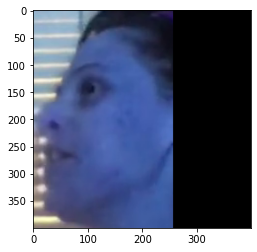

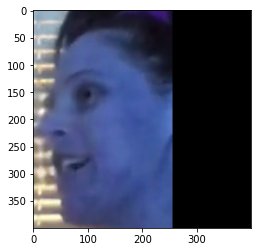

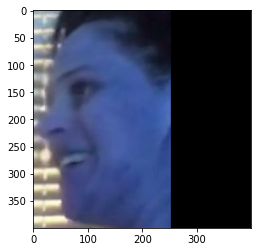

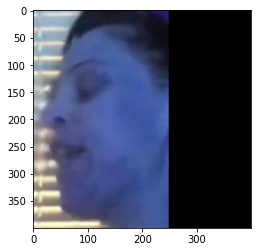

For each:


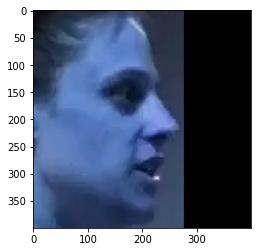

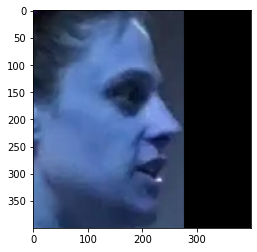

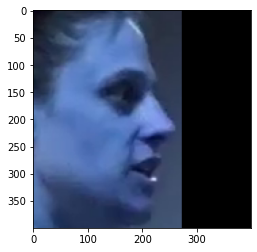

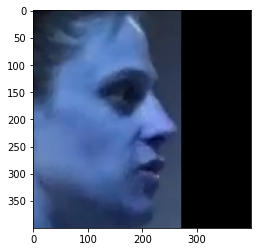

For each:


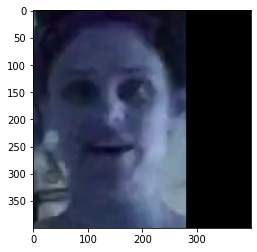

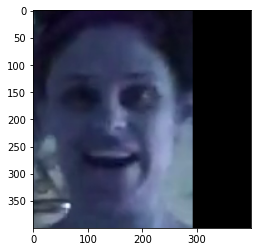

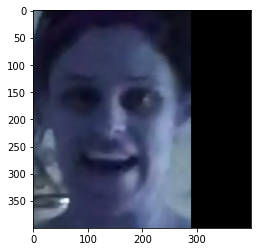

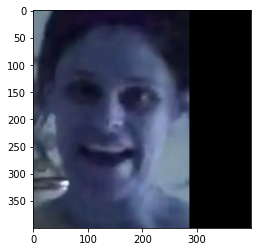

In [0]:
for i in range(0, len(Data), 40):
  print("For each:")
  for j in range(i, i + 4):
    plt.imshow(Data[j])
    plt.show()

In [0]:
dataframe.head()

,filename,label,split,original,video_path
0,owxbbpjpch.mp4,1,train,wynotylpnm.mp4,/content/drive/My Drive/Dataset/dfdc_train_part_0/owxbbpjpch.mp4
1,vpmyeepbep.mp4,0,train,NaN,/content/drive/My Drive/Dataset/dfdc_train_part_0/vpmyeepbep.mp4
2,fzvpbrzssi.mp4,0,train,NaN,/content/drive/My Drive/Dataset/dfdc_train_part_0/fzvpbrzssi.mp4
3,htorvhbcae.mp4,1,train,wclvkepakb.mp4,/content/drive/My Drive/Dataset/dfdc_train_part_0/htorvhbcae.mp4
4,fckxaqjbxk.mp4,1,train,vpmyeepbep.mp4,/content/drive/My Drive/Dataset/dfdc_train_part_0/fckxaqjbxk.mp4


MODEL: input is an image
Output is a list of two elements

In [0]:
from tensorflow.keras import regularizers

image_input = layers.Input(shape = (200, 200, 3))
x = layers.Conv2D(32, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.025))(image_input)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(64, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.025))(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(64, 3, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.025))(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x) #creates 1D tensor so we can add fully connected layers

x = layers.Dense(128, activation='relu')(x)

output = layers.Dense(2, activation ='sigmoid')(x)

model = Model(image_input, output)


In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0   

In [0]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.025),
    metrics = ['acc']
)

In [0]:
#X_train = []
#Y_train = []
#X_test = []
#Y_test = []
shuffle(data[0])

X_train = np.array([i[0] for i in tqdm(data[0])])
X_train = X_train.reshape(-1, 200, 200, 3)
Y_train = np.array([i[1] for i in data[0]])
#for each in data[0]:
#  X_train.append(each[0].reshape(-1, 200, 200, 3))
#  Y_train.append(each[1])

#for each in data[1]:
#  X_test.append(each[0].reshape(-1, 200, 200, 3))
#  Y_test.append(each[1])
shuffle(data[1])
X_test = np.array([i[0] for i in tqdm(data[1])])
X_test = X_test.reshape(-1, 200, 200, 3)
Y_test = np.array([i[1] for i in data[1]])

#train and test set splitting is done

In [0]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_test.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_val:", Y_test.shape)

Shape of X_train: (2850, 200, 200, 3)
Shape of X_val: (1050, 200, 200, 3)
Shape of Y_train: (2850, 2)
Shape of Y_val: (1050, 2)


In [0]:
h = model.fit(X_train, Y_train, batch_size = 32, epochs = 50, validation_data = (X_test, Y_test))

Train on 2850 samples, validate on 1050 samples
Epoch 1/50
2850/2850 [==============================] - 9s 3ms/sample - loss: 2.8175 - acc: 0.8884 - val_loss: 1.0256 - val_acc: 0.9429
Epoch 2/50
2850/2850 [==============================] - 9s 3ms/sample - loss: 1.2129 - acc: 0.9053 - val_loss: 1.0653 - val_acc: 0.9429
Epoch 3/50
2850/2850 [==============================] - 9s 3ms/sample - loss: 1.2231 - acc: 0.9053 - val_loss: 1.1367 - val_acc: 0.9429
Epoch 4/50
2850/2850 [==============================] - 9s 3ms/sample - loss: 1.2434 - acc: 0.9053 - val_loss: 1.0861 - val_acc: 0.9429
Epoch 5/50
2850/2850 [==============================] - 9s 3ms/sample - loss: 1.2507 - acc: 0.9053 - val_loss: 1.0932 - val_acc: 0.9429
Epoch 6/50
2850/2850 [==============================] - 9s 3ms/sample - loss: 1.2475 - acc: 0.9053 - val_loss: 1.1014 - val_acc: 0.9429
Epoch 7/50
2528/2850 [=========================>....] - ETA: 0s - loss: 1.2549 - acc: 0.9039

KeyboardInterrupt: ignored

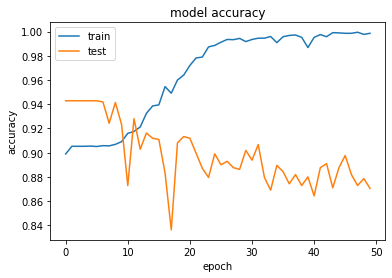

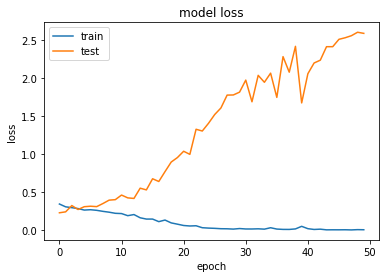

In [0]:
# summarize history for accuracy
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

L2 = 0.0001

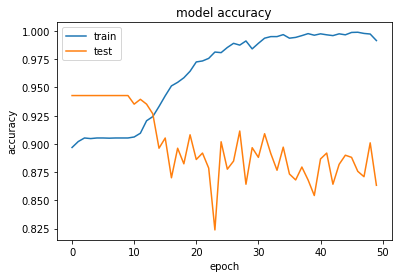

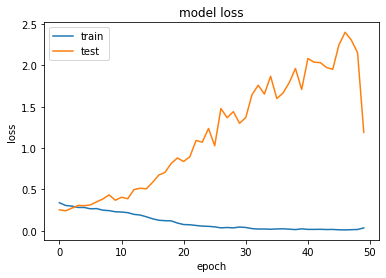

In [0]:
# summarize history for accuracy
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

L2 = 0.001

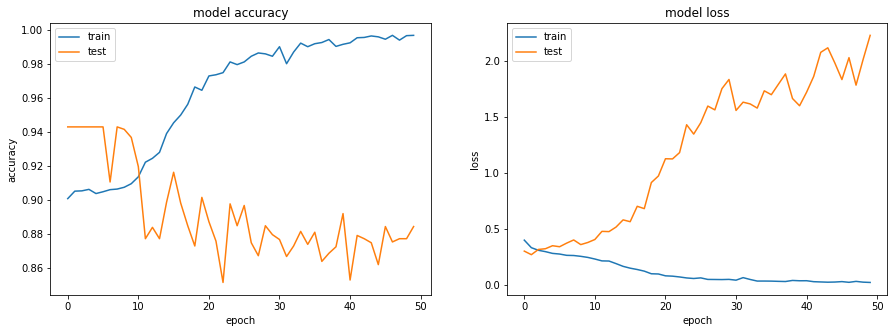

In [0]:
plt.figure(figsize=(15, 5))
# summarize history for accuracy
plt.subplot(121)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

l1, l2 = 0.001, 0.001

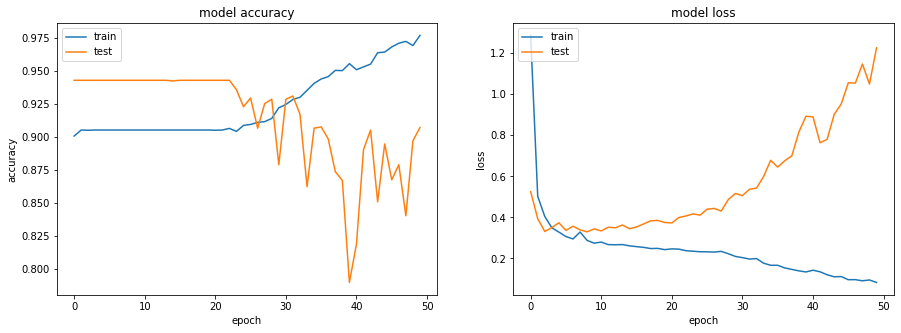

In [0]:
plt.figure(figsize=(15, 5))
# summarize history for accuracy
plt.subplot(121)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

l1=0.001, l2=0.005

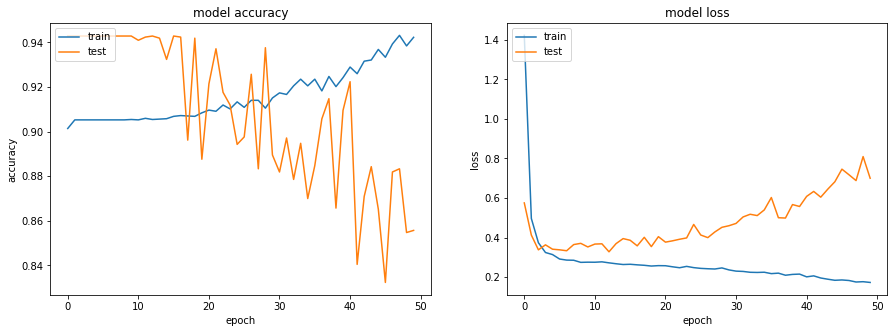

In [0]:
plt.figure(figsize=(15, 5))
# summarize history for accuracy
plt.subplot(121)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
prob = model.predict(X_test[0].reshape(1, 200, 200, 3))
print(prob)
#print(np.argmax(prob, axis = 0))

[[0.79346484 0.1595567 ]]


In [0]:
correct = 0
for i in range(0, len(X_test), 30):
  realProb = 0
  fakeProb = 0
  for j in range(i, i + 30):
    perframe = model.predict(X_test[j].reshape(1, 200, 200, 3))
    index = np.argmax(perframe[0])
    if index == 0:
      #[1, 0] ---> fake
      #[0, 1] ---> real
      fakeProb += 1
    else:
      realProb += 1
  actualProb = np.argmax(Y_test[i])
  if fakeProb > realProb:
    if actualProb == 0:
      correct += 1
  else:
    if actualProb == 1:
      correct += 1

#print("Actual accuracy: " + (str(correct / (len(X_test) / 30))))